In [ ]:
# https://stackoverflow.com/questions/61552475/properly-set-up-exponential-decay-of-learning-rate-in-tensorflow
# https://github.com/nicknochnack/FaceDetection/blob/main/FaceDetection.ipynb
# https://www.youtube.com/watch?v=N_W4EYtsa10&t=564s&ab_channel=NicholasRenotte

In [ ]:
!gdown 
!unzip LG4000.zip

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import csv
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_size = 224

#Reading train data

In [3]:
train_labels = []
train_imgs = []

csvreader = None
with open(f"/content/LG4000/train.csv", "r") as file:
    csvreader = list(csv.reader(file))

csvreader.pop(0) # Removing the header line of the file

for row in csvreader:
    img_path = "/content/LG4000/images/" + row[0] + ".tiff"
    img = img_to_array(load_img(img_path, target_size=(img_size,img_size))) / 255.
    train_imgs.append(img)

    train_labels.append([row[6], row[7], row[8]])

del csvreader

train_labels = np.array(train_labels).astype(np.int32)
train_imgs = np.array(train_imgs).astype(np.float32)

#Building the model

In [4]:
from tensorflow.keras.applications import EfficientNetB3, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, Flatten, BatchNormalization, Rescaling, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError, Huber
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [5]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode = 'min',
    save_weights_only=True,
    verbose=1
)

def build_model():
  shape = (img_size, img_size, 3)
  input_layer = Input(shape = shape)

  vgg = VGG16(include_top = False, weights='imagenet')
  for layer in vgg.layers:
    layer.trainable = False

  vgg                = vgg(input_layer)
  batch              = BatchNormalization()(vgg)
  globalPooling      = GlobalAveragePooling2D()(batch)

  dropout1           = Dropout(0.15)(globalPooling)
  dense1             = Dense(256, activation='relu')(dropout1)

  dropout2           = Dropout(0.15)(dense1)
  final_dense_shared = Dense(256, activation='relu')(dropout2)

  position_and_radius = Dense(3, name="position_and_radius")(final_dense_shared)

  new_model = Model(inputs = input_layer, outputs = position_and_radius)

  return new_model

model = build_model()
#model.summary()


58889256/58889256 [==============================] - 0s 0us/step


#Training the model

In [8]:
model.load_weights("best_model.h5")

In [6]:
optimizer = SGD(learning_rate = 0.002, momentum = 0.85)
loss = Huber(delta=0.125)

model.compile(optimizer = optimizer, loss = loss)

In [9]:
history = model.fit(
    train_imgs,
    train_labels,
    epochs = 50,
    batch_size = 16,
    validation_split = 0.2,
    shuffle = True,
    callbacks = [checkpoint_callback]
)

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 0.9250
Epoch 1: val_loss did not improve from 0.55959
150/150 [==============================] - 13s 86ms/step - loss: 0.9250 - val_loss: 0.6738
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.9115
Epoch 2: val_loss did not improve from 0.55959
150/150 [==============================] - 13s 85ms/step - loss: 0.9115 - val_loss: 0.5858
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.9514
Epoch 3: val_loss did not improve from 0.55959
150/150 [==============================] - 13s 85ms/step - loss: 0.9514 - val_loss: 0.6649
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 0.9195
Epoch 4: val_loss did not improve from 0.55959
150/150 [==============================] - 13s 85ms/step - loss: 0.9195 - val_loss: 0.5729
Epoch 5/50
150/150 [==============================] - ETA: 0s - loss: 0.9095
Epoch 5: val_loss improved from 0.55959 to 0.53556, saving mode

In [ ]:
model.save("x_y_modelo.h5")

In [ ]:
# @title
import matplotlib.pyplot as plt
import re
# Find all available metrics in the history
metrics = list(filter(lambda x: not re.search('val_', x), history.history.keys()))

# Create subplots
num_plots = len(metrics)
fig, axes = plt.subplots(num_plots, 1, figsize=(8, 4 * num_plots))

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i] if num_plots > 1 else axes
    ax.plot(history.history[metric], label=metric)
    val_metric = 'val_' + metric
    if val_metric in history.history:
        ax.plot(history.history[val_metric], label=val_metric)
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.title())
    ax.legend()

plt.tight_layout()
plt.show()

#Testing the model

In [10]:
try:
    del train_imgs
    del train_labels
except:
    pass

In [12]:
test_imgs_path = []

csvreader = None
with open(f"/content/LG4000/verification-subject-disjoint.csv", "r") as file:
    csvreader = list(csv.reader(file))

csvreader.pop(0) # Removing the header line of the file

for i in range (len(csvreader)):
    temp = csvreader.pop()

    img_path = "/content/LG4000/images/" + temp[0] + ".tiff"
    test_imgs_path.append(img_path)


del csvreader

test_imgs_path = np.array(test_imgs_path)

1/1 [==============================] - 1s 810ms/step


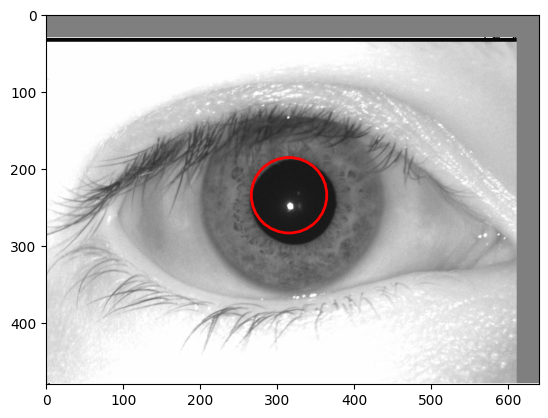

[315.93433  234.63776   49.957813]
1/1 [==============================] - 0s 30ms/step


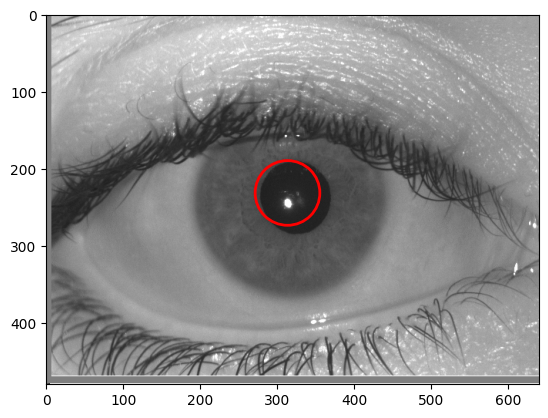

[313.24503  231.24844   42.919033]
1/1 [==============================] - 0s 19ms/step


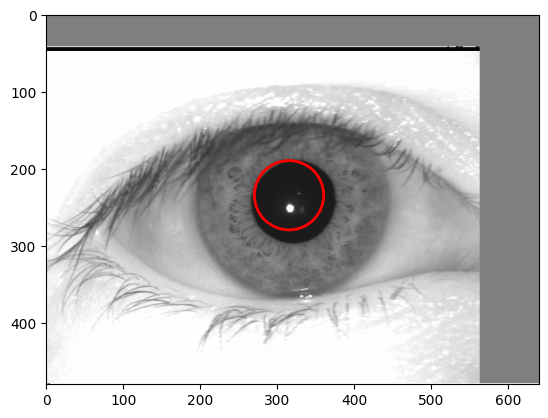

[315.86484  234.30861   45.171658]
1/1 [==============================] - 0s 19ms/step


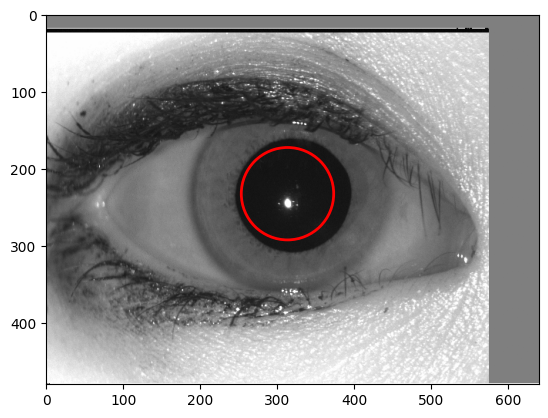

[313.63104 232.32074  60.26133]
1/1 [==============================] - 0s 21ms/step


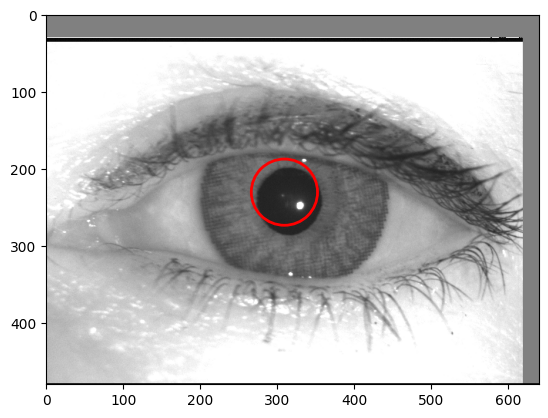

[309.1862   230.30125   43.196674]
1/1 [==============================] - 0s 18ms/step


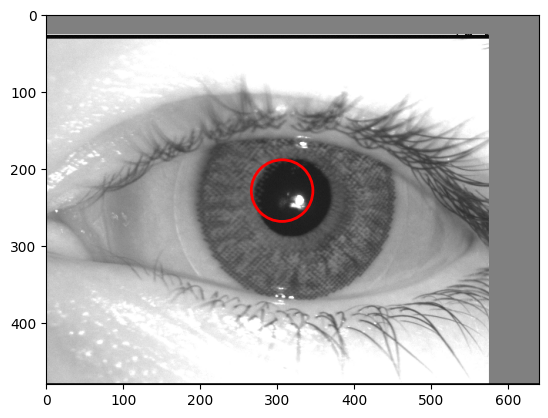

[306.4224   228.89154   40.541378]
1/1 [==============================] - 0s 19ms/step


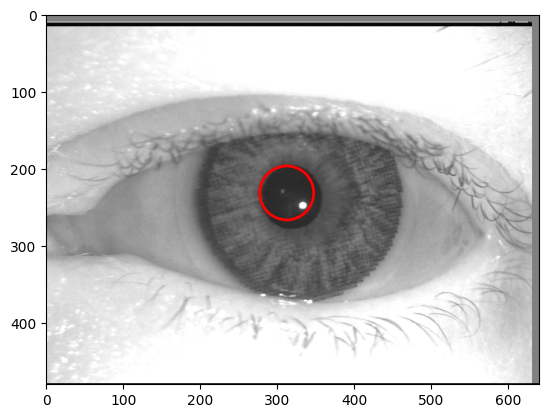

[312.84525  231.95456   35.088264]
1/1 [==============================] - 0s 23ms/step


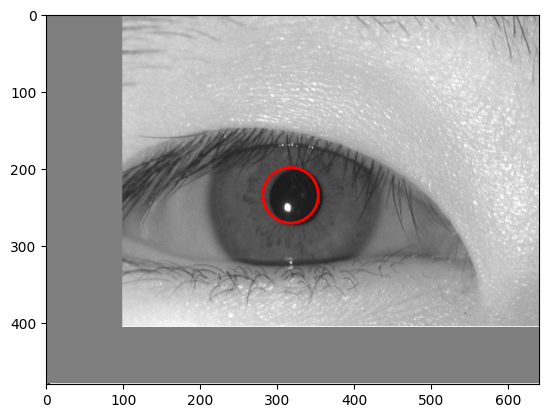

[317.45108  234.29535   36.372143]
1/1 [==============================] - 0s 23ms/step


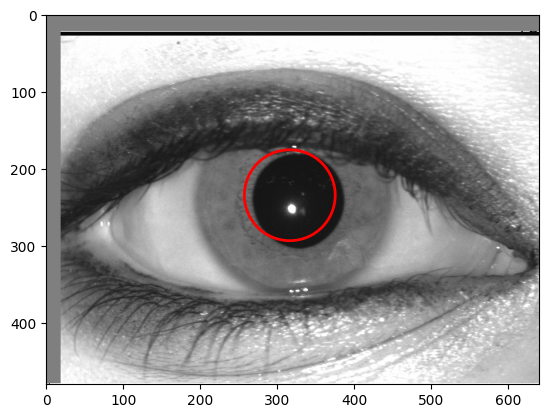

[316.24338 234.6216   59.91138]
1/1 [==============================] - 0s 18ms/step


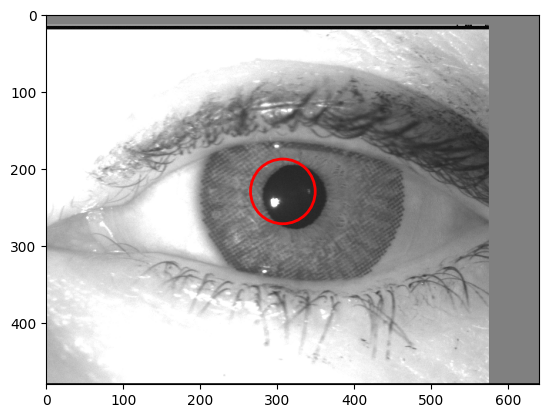

[307.62753  229.43594   42.168415]
1/1 [==============================] - 0s 39ms/step


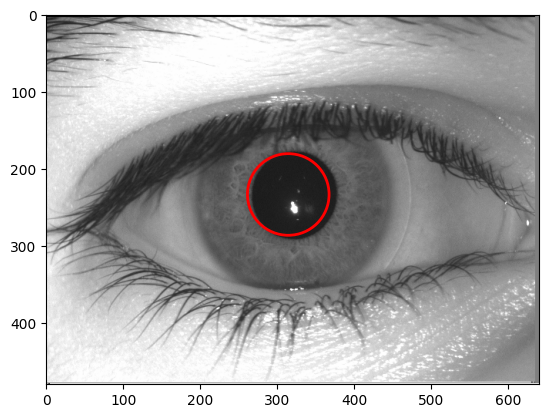

[314.65787  233.5631    53.749096]
1/1 [==============================] - 0s 26ms/step


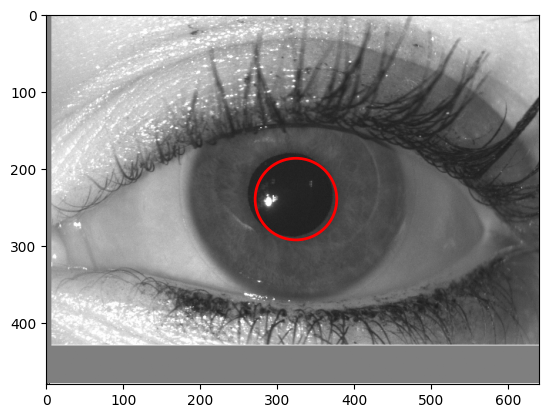

[324.5311   239.53893   53.172913]
1/1 [==============================] - 0s 38ms/step


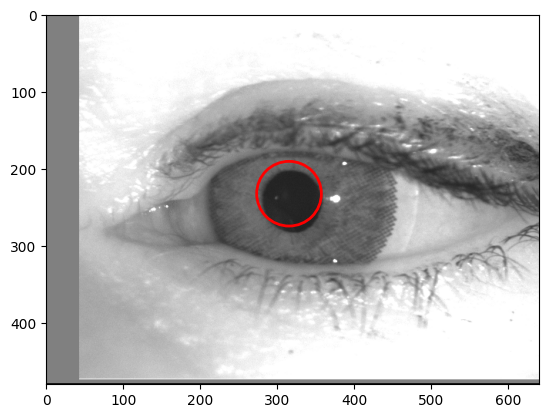

[315.10605  232.82924   42.333004]
1/1 [==============================] - 0s 33ms/step


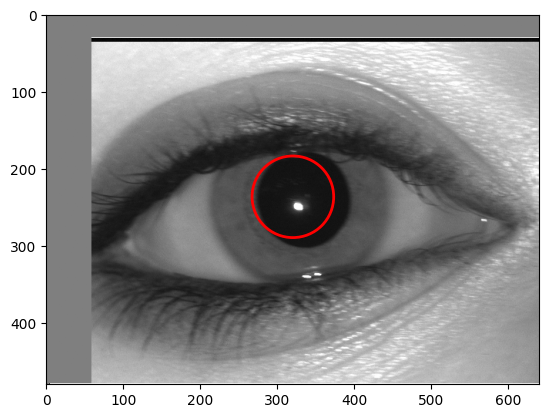

[320.95718  236.7507    53.308033]
1/1 [==============================] - 0s 27ms/step


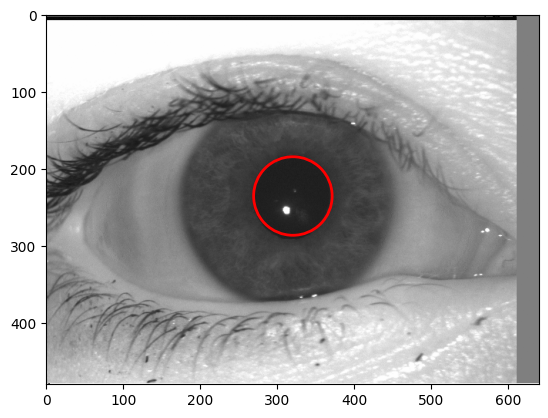

[320.34036  235.92307   51.751965]
1/1 [==============================] - 0s 29ms/step


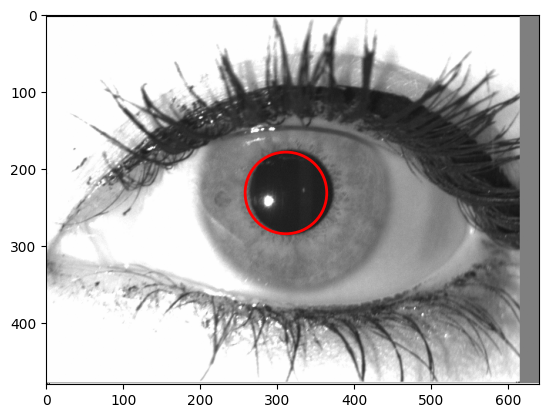

[311.12003  231.72296   53.108334]
1/1 [==============================] - 0s 23ms/step


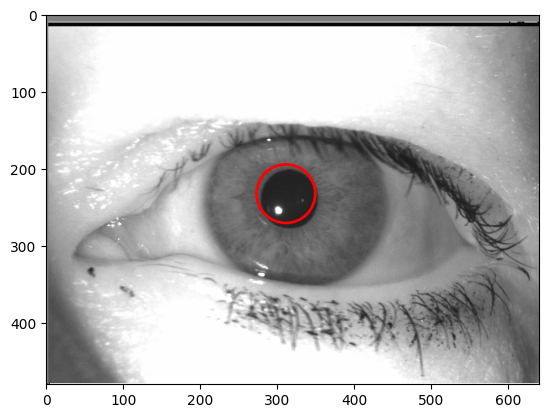

[311.55078 232.37958  38.73601]
1/1 [==============================] - 0s 32ms/step


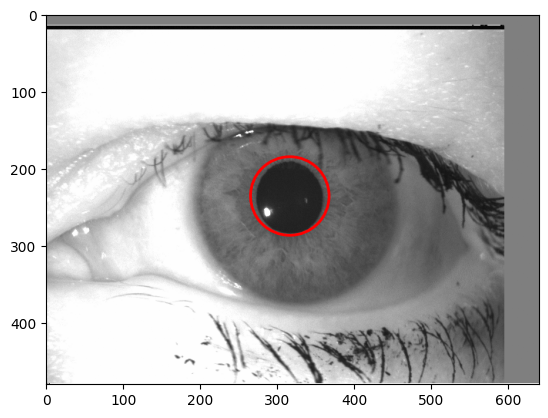

[316.4518   235.63478   51.945766]
1/1 [==============================] - 0s 30ms/step


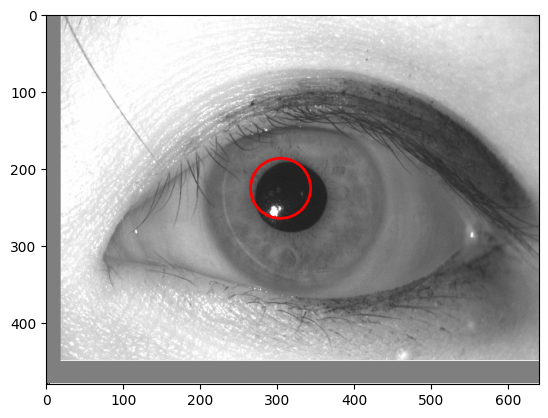

[304.7059  225.60439  39.66522]
1/1 [==============================] - 0s 36ms/step


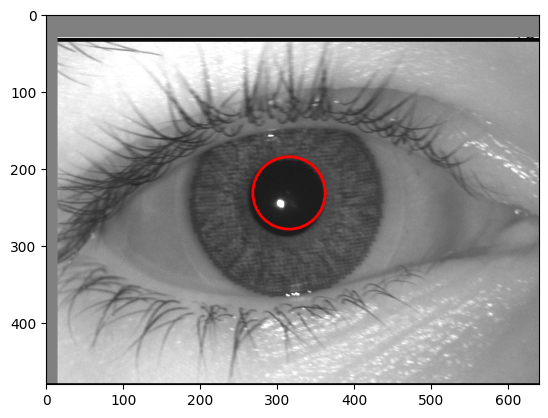

[315.45865  231.63458   47.124588]
1/1 [==============================] - 0s 30ms/step


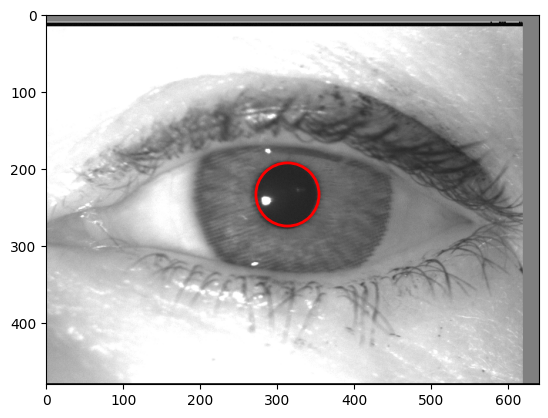

[313.55914 233.78561  41.73435]
1/1 [==============================] - 0s 28ms/step


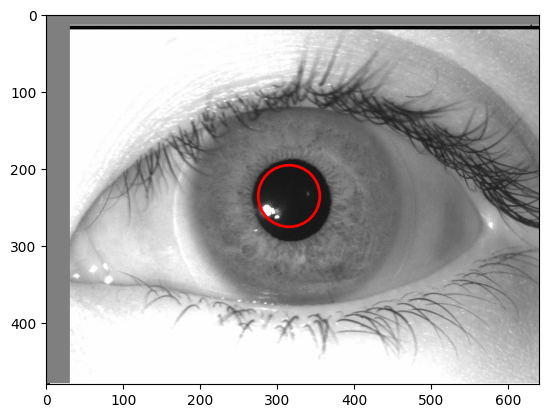

[315.84082  235.6644    40.689278]
1/1 [==============================] - 0s 36ms/step


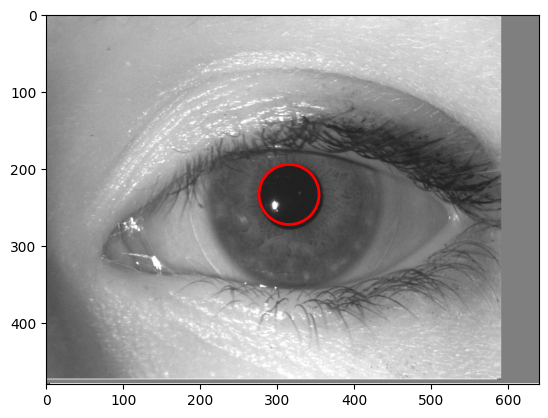

[315.3672   233.52284   39.983875]
1/1 [==============================] - 0s 31ms/step


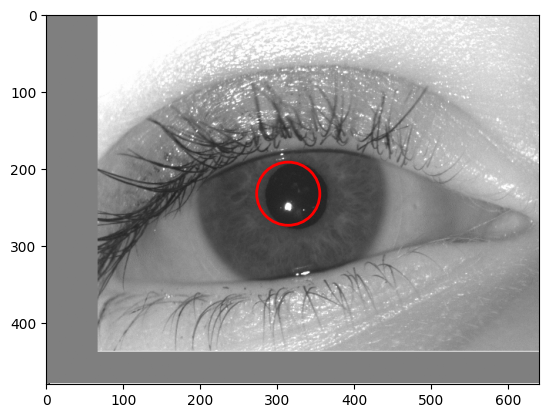

[314.74896  232.76393   41.381397]
1/1 [==============================] - 0s 23ms/step


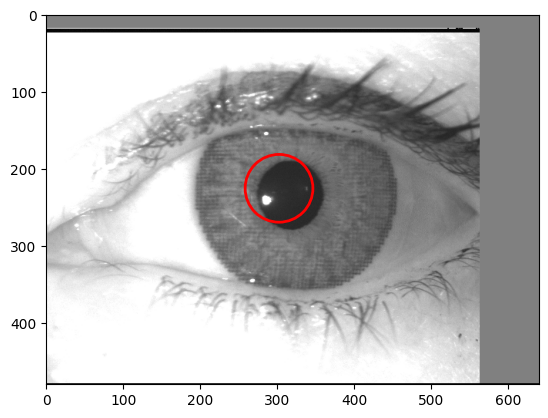

[302.69772  225.48227   44.859554]
1/1 [==============================] - 0s 26ms/step


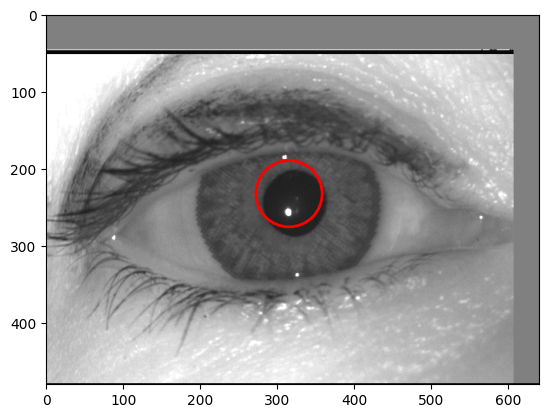

[315.76776 232.6463   43.06913]
1/1 [==============================] - 0s 27ms/step


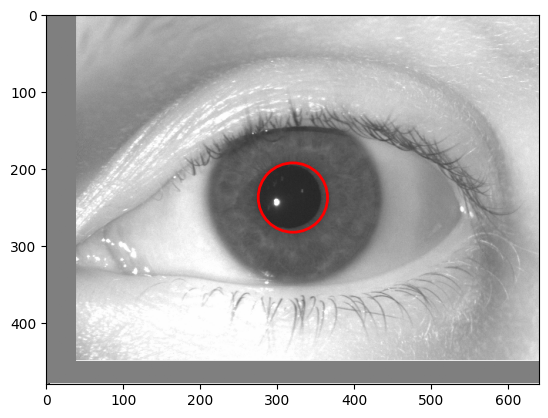

[320.25955  237.30336   45.279552]
1/1 [==============================] - 0s 25ms/step


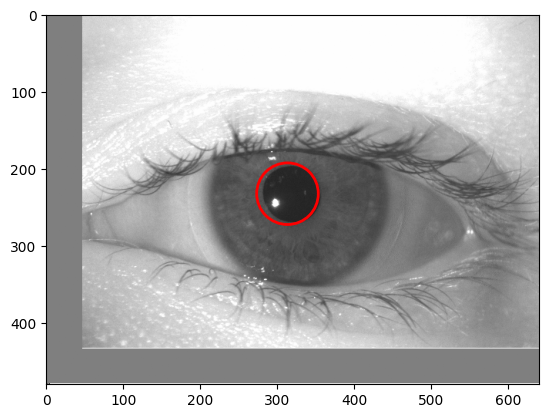

[313.6904   232.71982   40.324596]
1/1 [==============================] - 0s 30ms/step


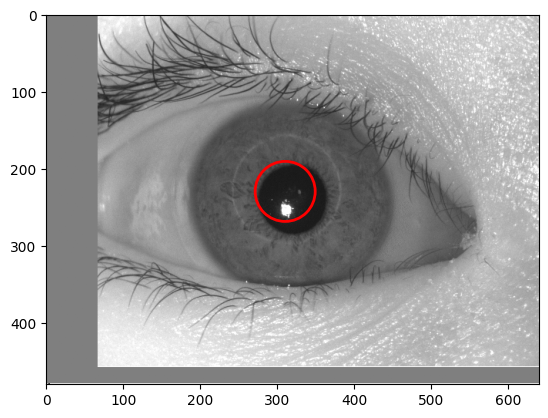

[310.63834 229.17615  39.08266]
1/1 [==============================] - 0s 31ms/step


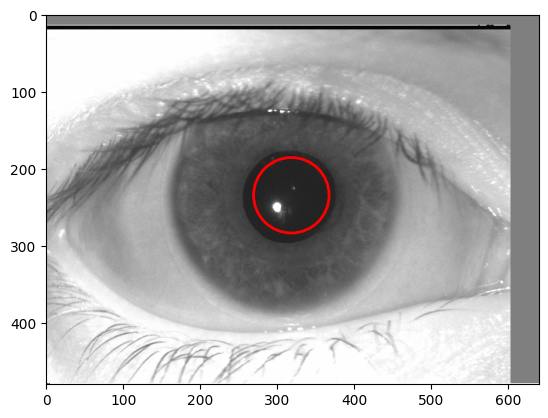

[318.38913 234.89511  49.32898]
1/1 [==============================] - 0s 30ms/step


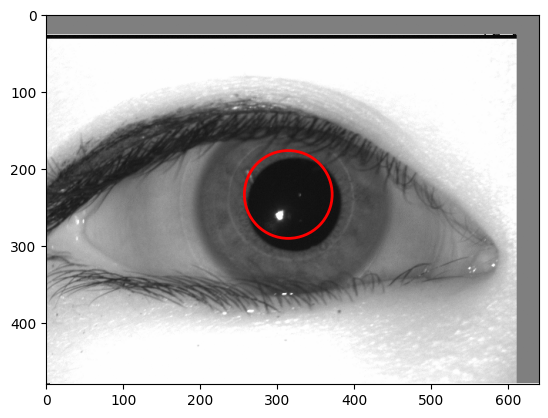

[314.51935 233.97835  57.78596]
1/1 [==============================] - 0s 27ms/step


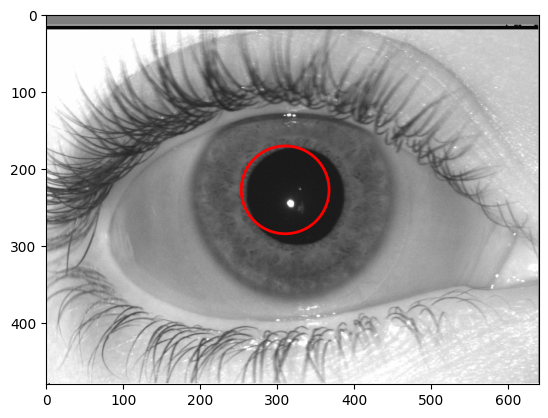

[310.04974  227.74527   57.245926]
1/1 [==============================] - 0s 27ms/step


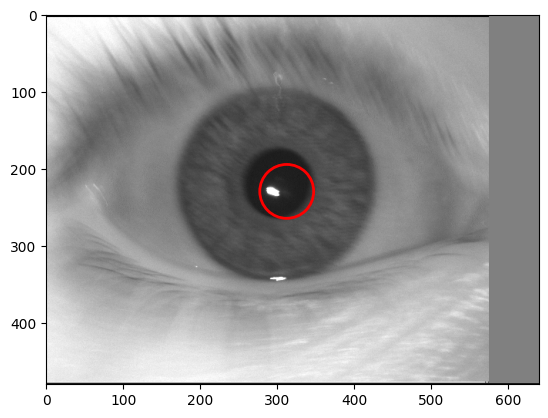

[312.12564  229.49593   35.372772]
1/1 [==============================] - 0s 34ms/step


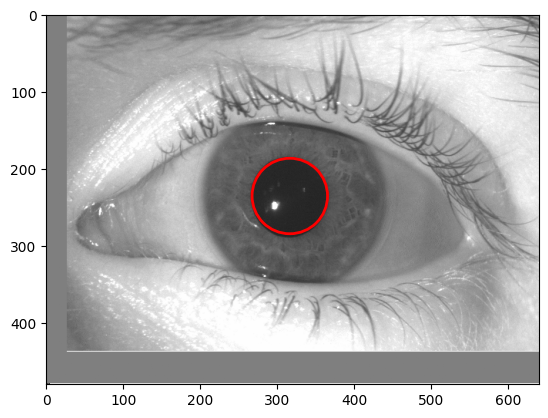

[316.26486 235.37881  49.755  ]
1/1 [==============================] - 0s 33ms/step


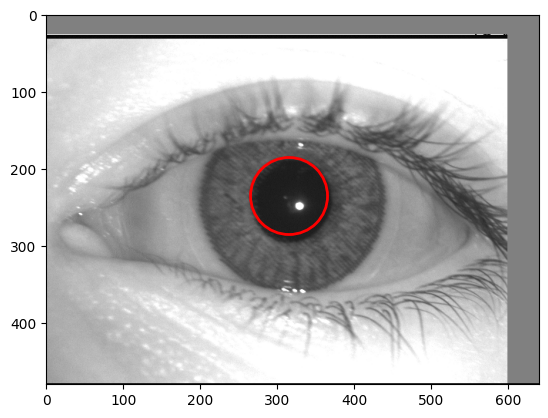

[315.75623  235.11263   50.820736]
1/1 [==============================] - 0s 27ms/step


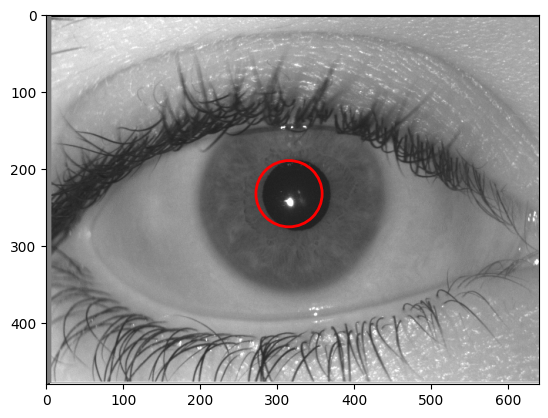

[315.3464   232.38951   43.831787]
1/1 [==============================] - 0s 25ms/step


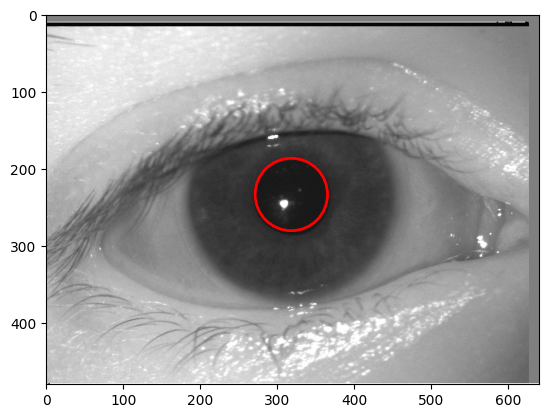

[318.36685 233.8331   47.24744]
1/1 [==============================] - 0s 27ms/step


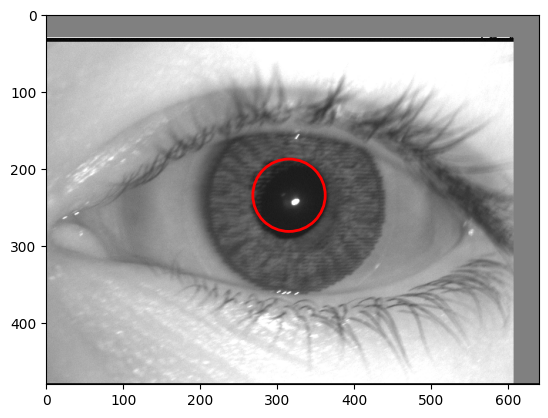

[315.24203  234.45381   47.366917]
1/1 [==============================] - 0s 46ms/step


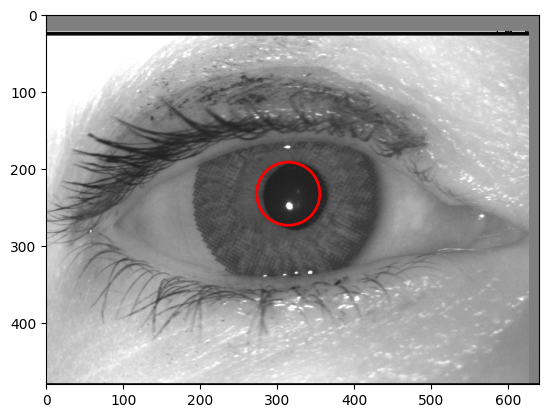

[314.74078 232.04118  41.22019]
1/1 [==============================] - 0s 51ms/step


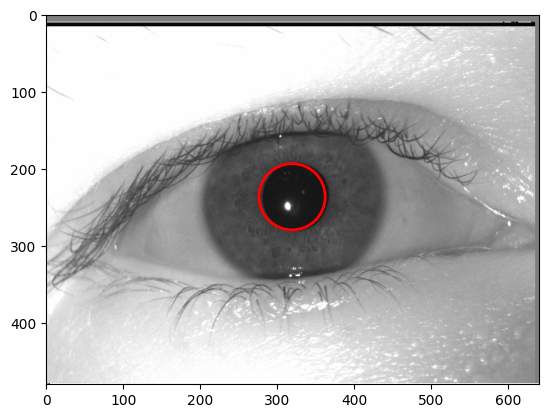

[319.3491   236.66475   43.759624]


In [13]:
import matplotlib.patches as patches
from matplotlib import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import time

def show_image_with_circle(image_array, x_center, y_center, radius):
    # Make a copy of the input image to avoid modifying the original
    image_with_circle = np.copy(image_array)

    # Ensure the circle coordinates and radius are within the image dimensions
    x_center = int(np.clip(x_center, 0, image_with_circle.shape[1] - 1))
    y_center = int(np.clip(y_center, 0, image_with_circle.shape[0] - 1))
    radius = int(radius)

    # Draw the circle on the image
    color = (1, 0, 0)
    linewidth = 2  # Line width of the circle
    plt.imshow(image_with_circle)

    # Create a Circle patch for the circle
    circle = Circle((x_center, y_center), radius, fill=False, edgecolor=color, linewidth=linewidth)

    # Add the circle to the current axis
    plt.gca().add_patch(circle)

    # Display the image with the circle
    #plt.axis('off')
    plt.show()


#Showing random images from dataset
np.random.seed(int(time.time()))
np.random.shuffle(test_imgs_path)
for i in range (15,55):

    img = img_to_array(load_img(test_imgs_path[i])) / 255.

    img_prediction = img_to_array(load_img(test_imgs_path[i],  target_size=(img_size,img_size))) / 255.

    temp = np.array([img_prediction])

    predicao = (model.predict(temp))[0]

    x = predicao[0]
    y = predicao[1]
    radius = predicao[2]

    show_image_with_circle(img, x, y, radius)
    print(predicao)